倒入一些必要的库

In [22]:
import datetime

import keras.activations
import keras.losses
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import SVG
from keras.layers.core import Dense, Dropout
from keras.layers.rnn.lstm import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection
from sklearn import preprocessing

必要的配置

In [23]:
# # 查询当前系统所有字体
# from matplotlib.font_manager import FontManager
#
# mpl_fonts = set(f.name for f in FontManager().ttflist)
#
# print('all font list get from matplotlib.font_manager:')
# for f in sorted(mpl_fonts):
#     print('\t' + f)

# 显示所有列
pd.set_option('display.max_columns', None)
# 绘图时显示中文字体
matplotlib.rc("font", family='Songti SC')

读取, 并且查看数据

In [24]:
# 读取数据，0对应第一支股票，1对应第二只，以此类推
origin_data = pd.read_excel('data.xlsx', 0)
print('shape: ', origin_data.shape)
print('columns: ', origin_data.columns)
origin_data

shape:  (6935, 12)
columns:  Index(['时间', '开盘', '最高', '最低', '收盘', '涨幅', '振幅', '总手', '金额', '换手%', '成交次数',
       'target'],
      dtype='object')


,时间,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数,target
0,"1991-04-03,三",49.00,49.00,49.00,49.00,--,--,100,4900,0.000,--,48.76
1,"1991-04-04,四",48.76,48.76,48.76,48.76,-0.0049,0,300,14628,0.001,--,48.52
2,"1991-04-05,五",48.52,48.52,48.52,48.52,-0.0049,0,200,9704,0.001,--,48.28
3,"1991-04-06,六",48.28,48.28,48.28,48.28,-0.0049,0,700,33796,0.003,--,48.04
4,"1991-04-08,一",48.04,48.04,48.04,48.04,-0.005,0,200,9608,0.001,--,47.80
...,...,...,...,...,...,...,...,...,...,...,...,...
6930,"2020-04-08,三",1690.47,1695.47,1670.46,1677.96,-0.0074,0.0148,52871614,676604870,0.272,35955,1672.96
6931,"2020-04-09,四",1690.47,1691.72,1670.46,1672.96,-0.003,0.0127,40855377,522027890,0.211,37688,1679.21
6932,"2020-04-10,五",1675.46,1702.97,1661.71,1679.21,0.0037,0.0247,66667495,853689950,0.344,40945,1654.21
6933,"2020-04-13,一",1664.21,1669.21,1639.21,1654.21,-0.0149,0.0179,44621440,562008050,0.230,34911,1687.97


选取有价值的数据
序列号, 时间, 不作为输入数据

In [25]:
data = origin_data.iloc[:, 1:]
data.head(5)

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数,target
0,49.00,49.00,49.00,49.00,--,--,100,4900,0.000,--,48.76
1,48.76,48.76,48.76,48.76,-0.0049,0,300,14628,0.001,--,48.52
2,48.52,48.52,48.52,48.52,-0.0049,0,200,9704,0.001,--,48.28
3,48.28,48.28,48.28,48.28,-0.0049,0,700,33796,0.003,--,48.04
4,48.04,48.04,48.04,48.04,-0.005,0,200,9608,0.001,--,47.80


查看空值

In [26]:
data.isna().sum()

开盘        0
最高        0
最低        0
收盘        0
涨幅        0
振幅        0
总手        0
金额        0
换手%       0
成交次数      0
target    0
dtype: int64

查看选取的数据

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6935 entries, 0 to 6934
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   开盘      6935 non-null   float64
 1   最高      6935 non-null   float64
 2   最低      6935 non-null   float64
 3   收盘      6935 non-null   float64
 4   涨幅      6935 non-null   object 
 5   振幅      6935 non-null   object 
 6   总手      6935 non-null   int64  
 7   金额      6935 non-null   int64  
 8   换手%     6935 non-null   float64
 9   成交次数    6935 non-null   object 
 10  target  6935 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 596.1+ KB


虽然没有空值,但是<br />
经过检查, 发现有些地方有类似'--'的地方<br />
显示一下这些地方,看看如何处理<br />

In [28]:
data.query('`涨幅` == "--"')

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数,target
0,49.0,49.0,49.0,49.0,--,--,100,4900,0.0,--,48.76


In [29]:
data.query('`振幅` == "--"')

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数,target
0,49.0,49.0,49.0,49.0,--,--,100,4900,0.0,--,48.76


In [30]:
data.query('`成交次数` == "--"')

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数,target
0,49.00,49.00,49.00,49.00,--,--,100,4900,0.000,--,48.76
1,48.76,48.76,48.76,48.76,-0.0049,0,300,14628,0.001,--,48.52
2,48.52,48.52,48.52,48.52,-0.0049,0,200,9704,0.001,--,48.28
3,48.28,48.28,48.28,48.28,-0.0049,0,700,33796,0.003,--,48.04
4,48.04,48.04,48.04,48.04,-0.005,0,200,9608,0.001,--,47.80
...,...,...,...,...,...,...,...,...,...,...,...
186,45.03,45.03,42.93,43.70,-0.028,0.0467,247500,7649890,0.627,--,40.62
187,43.70,43.70,40.62,40.62,-0.0705,0.0705,356300,10566240,0.902,--,42.30
188,40.62,42.30,39.99,42.30,0.0414,0.0569,455000,13100900,1.150,--,40.97
189,42.30,42.72,40.62,40.97,-0.0314,0.0496,432000,12880320,1.090,--,39.29


经过检查, 只有第一行涨幅和振幅缺失<br />
成交次数, 有191个空值, 无论是设为0, 或者取平均值, 都与现实差别较大<br />
注意空值集中在[0:189], 和额外一行189, 所以考虑直接丢弃<br />
所以, 最终解决方案是全部去掉<br />

In [31]:
clean_data = data.drop(data.query('`成交次数` == "--"').index)
clean_data

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数,target
190,40.90,40.90,38.73,39.29,-0.041,0.053,306200,8557120,0.775,0,38.80
191,39.22,39.50,38.66,38.80,-0.0125,0.0214,142900,3962000,0.362,0,38.17
192,38.94,38.94,37.82,38.17,-0.0162,0.0289,410500,11099000,1.040,0,39.92
193,38.10,40.27,38.10,39.92,0.0458,0.0569,234800,6521000,0.595,0,39.50
194,39.92,40.20,39.50,39.50,-0.0105,0.0175,242700,6853000,0.615,0,38.10
...,...,...,...,...,...,...,...,...,...,...,...
6930,1690.47,1695.47,1670.46,1677.96,-0.0074,0.0148,52871614,676604870,0.272,35955,1672.96
6931,1690.47,1691.72,1670.46,1672.96,-0.003,0.0127,40855377,522027890,0.211,37688,1679.21
6932,1675.46,1702.97,1661.71,1679.21,0.0037,0.0247,66667495,853689950,0.344,40945,1654.21
6933,1664.21,1669.21,1639.21,1654.21,-0.0149,0.0179,44621440,562008050,0.230,34911,1687.97


再次检查, 数据是否清洗完成

In [32]:
clean_data.query('`涨幅` == "--" | `振幅` == "--" | `成交次数` == "--"')

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数,target


确认clean_data中只包含float类型数据

In [33]:
clean_data = clean_data.astype('float')
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6744 entries, 190 to 6934
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   开盘      6744 non-null   float64
 1   最高      6744 non-null   float64
 2   最低      6744 non-null   float64
 3   收盘      6744 non-null   float64
 4   涨幅      6744 non-null   float64
 5   振幅      6744 non-null   float64
 6   总手      6744 non-null   float64
 7   金额      6744 non-null   float64
 8   换手%     6744 non-null   float64
 9   成交次数    6744 non-null   float64
 10  target  6744 non-null   float64
dtypes: float64(11)
memory usage: 632.2 KB


使用图表检查数据分布

array([[<AxesSubplot: title={'center': '开盘'}>,
        <AxesSubplot: title={'center': '最高'}>,
        <AxesSubplot: title={'center': '最低'}>],
       [<AxesSubplot: title={'center': '收盘'}>,
        <AxesSubplot: title={'center': '涨幅'}>,
        <AxesSubplot: title={'center': '振幅'}>],
       [<AxesSubplot: title={'center': '总手'}>,
        <AxesSubplot: title={'center': '金额'}>,
        <AxesSubplot: title={'center': '换手%'}>],
       [<AxesSubplot: title={'center': '成交次数'}>,
        <AxesSubplot: title={'center': 'target'}>, <AxesSubplot: >]],
      dtype=object)

/usr/local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


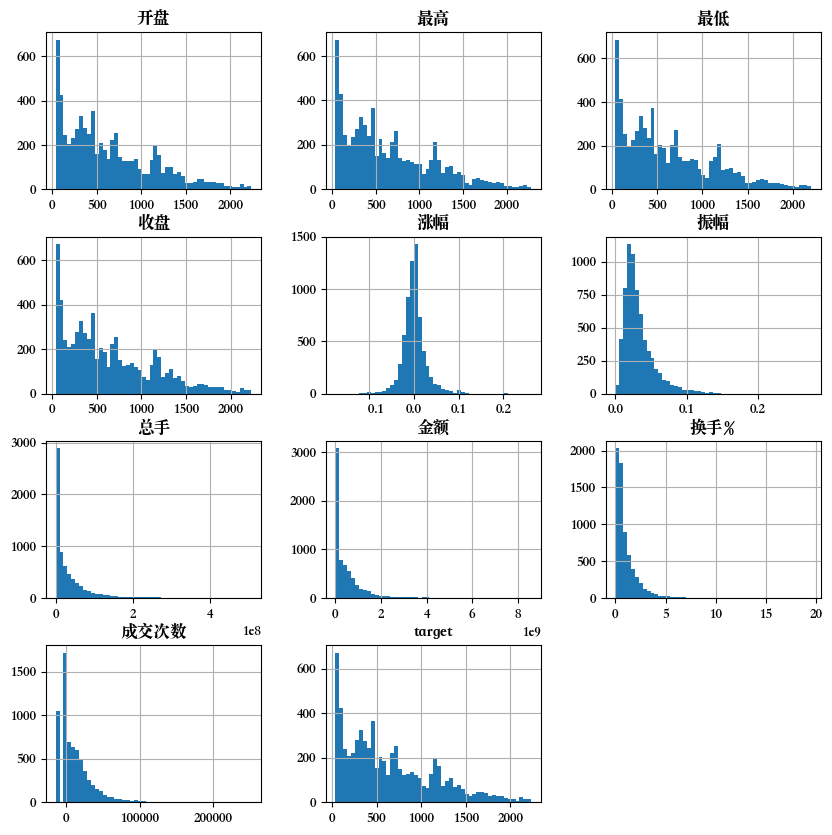

In [34]:
clean_data.hist(figsize=(10, 10), bins=50)

发现'成交次数'竟然出现了负值<br />
经过分析, 成交次数应该取绝对值

array([[<AxesSubplot: title={'center': '开盘'}>,
        <AxesSubplot: title={'center': '最高'}>,
        <AxesSubplot: title={'center': '最低'}>],
       [<AxesSubplot: title={'center': '收盘'}>,
        <AxesSubplot: title={'center': '涨幅'}>,
        <AxesSubplot: title={'center': '振幅'}>],
       [<AxesSubplot: title={'center': '总手'}>,
        <AxesSubplot: title={'center': '金额'}>,
        <AxesSubplot: title={'center': '换手%'}>],
       [<AxesSubplot: title={'center': '成交次数'}>,
        <AxesSubplot: title={'center': 'target'}>, <AxesSubplot: >]],
      dtype=object)

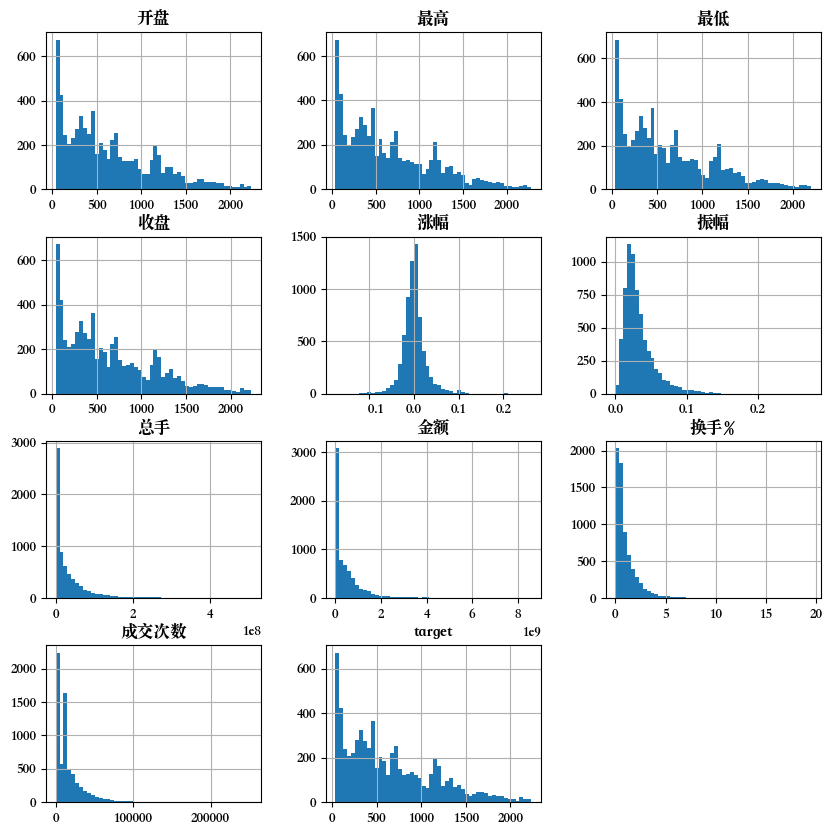

In [35]:
clean_data['成交次数'] = clean_data['成交次数'].apply(abs)
clean_data.hist(figsize=(10, 10), bins=50)

代码确认`成交次数`不会再包含负数

In [36]:
clean_data.query('`成交次数` < 0')

,开盘,最高,最低,收盘,涨幅,振幅,总手,金额,换手%,成交次数,target


确认数据没有问题了, 对数据进行归一化<br />
其中'涨幅', '振幅'为正态分布, 其余均为对数分布<br />
因为数据不呈现明显的正态分布, 所以使用min-max<br />
目标值为预期的股价, 不需要归一化<br />

array([[<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '2'}>],
       [<AxesSubplot: title={'center': '3'}>,
        <AxesSubplot: title={'center': '4'}>,
        <AxesSubplot: title={'center': '5'}>],
       [<AxesSubplot: title={'center': '6'}>,
        <AxesSubplot: title={'center': '7'}>,
        <AxesSubplot: title={'center': '8'}>],
       [<AxesSubplot: title={'center': '9'}>,
        <AxesSubplot: title={'center': '10'}>, <AxesSubplot: >]],
      dtype=object)

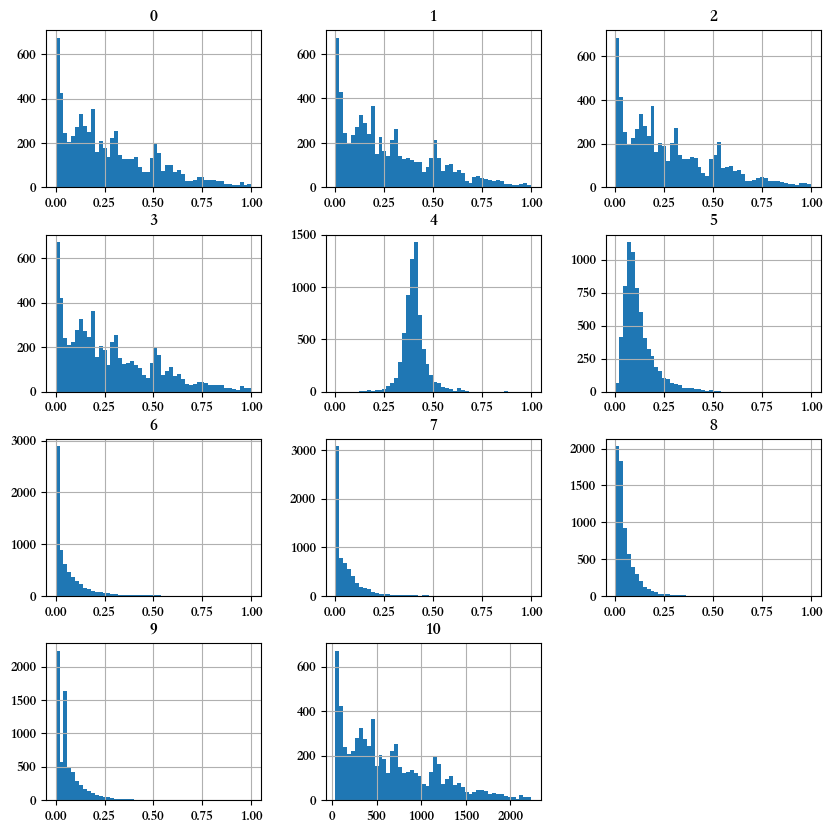

In [37]:
scaler = preprocessing.MinMaxScaler()
scaler_data = scaler.fit_transform(clean_data)
clean_data.to_numpy()
scaler_data[:, -1] = clean_data.to_numpy()[:, -1]
scaler_data = pd.DataFrame(scaler_data)
scaler_data.hist(figsize=(10, 10), bins=50)

切分训练集和测试集

In [38]:
# 拆分x和y
x = scaler_data.iloc[:, :-1]
y = scaler_data.iloc[:, -1]

# 拆分train和test
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=1234)

print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

x_train:  (5395, 10)
x_test:  (1349, 10)
y_train:  (5395,)
y_test:  (1349,)


# TensorFlow

配置log

In [39]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# DNN

构建一个DNN网络

In [40]:
dnn_model = Sequential()
dnn_model.add(Dense(128, input_dim=x_train.shape[1], activation=keras.activations.relu))
dnn_model.add(Dropout(0.2))
dnn_model.add(Dense(8, activation=keras.activations.relu))
dnn_model.add(Dropout(0.05))
dnn_model.add(Dense(1))
dnn_model.compile(loss=keras.losses.MSLE, optimizer=Adam())
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1408      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 1032      
                                                                 
 dropout_3 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,449
Trainable params: 2,449
Non-trainable params: 0
_________________________________________________________________


可视化模型

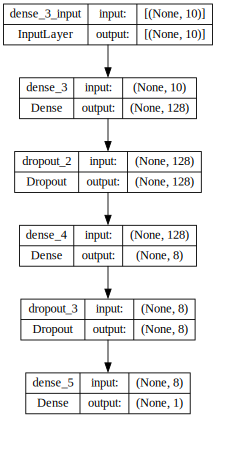

In [41]:
SVG(model_to_dot(dnn_model, True, dpi=64).create(prog='dot', format='svg'))


训练模型

In [46]:
result = dnn_model.fit(x_train, y_train, 256, 200, validation_data=(x_test, y_test), callbacks=[tensorboard_callback],
                       verbose=0)

经过训练, 10步左右就稳定了
显示训练效果:<br />
绘制训练 & 验证的准确率值<br />
绘制训练 & 验证的损失值<br />


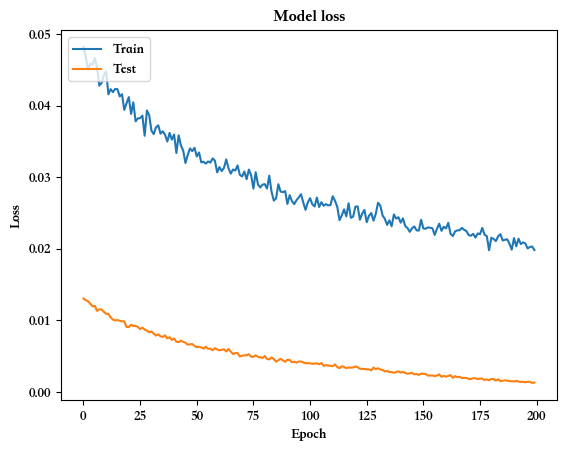

In [47]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# LSTM

为了LSTM, 进行数据重组

In [24]:
# 时间窗设置
window = 5
# 每一个序列的长度: window + 1, 其中前window个认为是训练数据, 最后一个为目标值
sequence_length = window + 1  #序列长度+1
# 重组的数据: shape(clean_data.length - sequence_length, sequence_length, feature + target)
result = []
# 循环 {数据长度-序列的长度} 次
for index in range(scaler_data.shape[0] - sequence_length):
    # 第index行到index+sequence_length
    result.append(scaler_data[index: index + sequence_length])
# 重组的数据为list, 转为ndarray
result = np.array(result)  #得到样本，样本形式为 window*feanum
# 重组的数据shape(clean_data.length - sequence_length, sequence_length, feature + target)
print('result.shape: ', result.shape)
print('样本数量: %d, 序列长度: %d, 特征+目标值: %d' % result.shape)

result.shape:  (6738, 6, 11)
样本数量: 6738, 序列长度: 6, 特征+目标值: 11


分割特征和目标值

In [25]:
# 第0维, 样本
# 第1维, 前window个为训练样本, 最后1个为目标帧
# 第2维, 前n个为特征, 最后1个为target
x = result[:, :-1, :-1]
y = result[:, -1, -1]

# 拆分train和test
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=1234)

print('x.shape: ', x.shape)
print('y.shape: ', y.shape)
print('x_train.shape: ', x_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

x.shape:  (6738, 5, 10)
y.shape:  (6738,)
x_train.shape:  (5390, 5, 10)
x_test.shape:  (1348, 5, 10)
y_train.shape:  (5390,)
y_test.shape:  (1348,)


In [26]:
#建立、训练模型过程
feature = x_train.shape[2]
lstm_model = Sequential()  #建立层次模型
lstm_model.add(LSTM(64, input_shape=(window, feature), return_sequences=True, dropout=0.2))  #建立LSTM层
lstm_model.add(LSTM(16, input_shape=(window, feature), return_sequences=False, dropout=0.05))  #建立LSTM层
lstm_model.add(Dense(4, activation=keras.activations.relu))  #建立全连接层
lstm_model.add(Dense(1, activation=keras.activations.relu))
lstm_model.compile(loss=keras.losses.MSLE, optimizer=Adam())
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             19200     
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 24,457
Trainable params: 24,457
Non-trainable params: 0
_________________________________________________________________


可视化模型

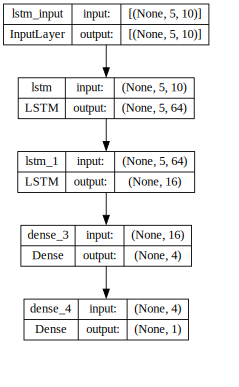

In [27]:
SVG(model_to_dot(lstm_model, True, dpi=64).create(prog='dot', format='svg'))


训练模型

In [28]:
result = lstm_model.fit(x, y, 256, 800, validation_split=0.2, callbacks=[tensorboard_callback], verbose=0)


经过大量的训练, 发现800次epoch, 模型基本就稳定了<br />
显示训练效果:<br />
绘制训练 & 验证的准确率值<br />
绘制训练 & 验证的损失值<br />


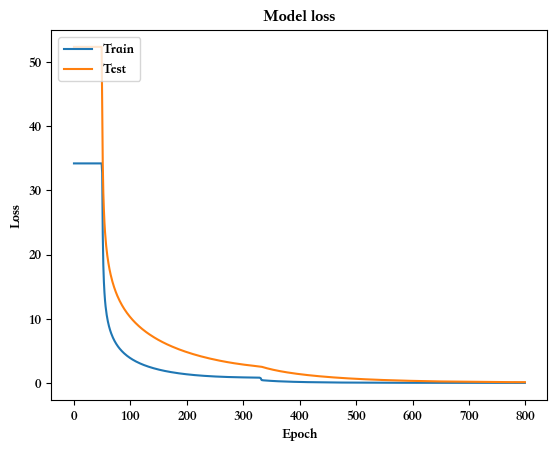

In [29]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()